In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, Dropout, GlobalAveragePooling2D,
                                    MaxPooling2D, Activation, Dense, Layer)
from tensorflow.keras.datasets import cifar10
from tensorflow.compat.v2.nn import local_response_normalization as lrn
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model
import cca_core
import correlations

x_predict, y_predict = correlations.make_test_data()

Image 0
Counts:  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Image 1
Counts:  [0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
Image 2
Counts:  [0, 0, 0, 1, 0, 0, 0, 0, 2, 0]
Image 3
Counts:  [1, 0, 0, 1, 0, 0, 0, 0, 2, 0]
Image 4
Counts:  [1, 0, 0, 1, 0, 0, 1, 0, 2, 0]
Image 5
Counts:  [1, 0, 0, 1, 0, 0, 2, 0, 2, 0]
Image 6
Counts:  [1, 1, 0, 1, 0, 0, 2, 0, 2, 0]
Image 7
Counts:  [1, 1, 0, 1, 0, 0, 3, 0, 2, 0]
Image 8
Counts:  [1, 1, 0, 2, 0, 0, 3, 0, 2, 0]
Image 9
Counts:  [1, 2, 0, 2, 0, 0, 3, 0, 2, 0]
Image 10
Counts:  [2, 2, 0, 2, 0, 0, 3, 0, 2, 0]
Image 11
Counts:  [2, 2, 0, 2, 0, 0, 3, 0, 2, 1]
Image 12
Counts:  [2, 2, 0, 2, 0, 1, 3, 0, 2, 1]
Image 13
Counts:  [2, 2, 0, 2, 0, 1, 3, 1, 2, 1]
Image 14
Counts:  [2, 2, 0, 2, 0, 1, 3, 1, 2, 2]
Image 15
Counts:  [2, 2, 0, 2, 0, 1, 3, 1, 3, 2]
Image 16
Counts:  [2, 2, 0, 2, 0, 2, 3, 1, 3, 2]
Image 17
Counts:  [2, 2, 0, 2, 0, 2, 3, 2, 3, 2]
Image 18
Counts:  [2, 2, 0, 2, 0, 2, 3, 2, 4, 2]
Image 19
Counts:  [2, 2, 0, 2, 0, 2, 4, 2, 4, 2]
Image 20
Counts:  [2, 2, 0, 2,

In [4]:
'''
SVCCA Pt. 1: Get flattened representations by avg pooling
'''

# For SVCCA, 1. prep data by avg pooling, 2. find threshold for each layer of each network
# 3. SVCCA each network with each other network, plot into graph


# Helper function to find threshold for each layer            
def search_threshold(acts):
    print('Getting threshold...')
    target = 0.99
    start = 0
    end = acts.shape[0]
    ans = -1
    while start <= end:
        mid = (start + end) // 2
        # Move to right side if target is 
        # greater. 
        s = np.linalg.svd(acts - np.mean(acts, axis=1, keepdims=True), full_matrices=False)[1]
        # Note: normally comparing floating points is a bad bad but the precision we need is low enough
        if (np.sum(s[:mid])/np.sum(s) <= target): 
            start = mid + 1;
        # Move left side. 
        else: 
            ans = mid; 
            end = mid - 1;
    # Prevent silent failure
    if ans == -1:
        raise
    print('Sanity check, achieved', np.sum(s[:ans])/np.sum(s), 'variance with', ans, 'neurons')
    return ans

num_images = len(x_predict) # 1000
num_networks = 10
num_layers = 9
rep_list = [[], [], [], [], [], [], [], [], []]
thresholds = np.empty((num_layers * num_networks))

# Loop through network instances
for i in range(num_networks):
    print('Working on model', str(i))
    K.clear_session()
    full_model = load_model('Models/Primary/Version_1/all_cnn_c_' + str(i) + '.h5')
    inp = full_model.input
    # Loop through layers
    for j in range(num_layers):
        print('Layer', str(j))
        out = full_model.layers[j].output
        temp_model = Model(inputs=inp, outputs=out)
        # Predict on x_predict
        print('Getting representation...')
        representations = temp_model.predict(x_predict)
        print('Old shape:', representations.shape)
        # Average pool along spacial dimensions, transpose to fit shape (imgs, neurons)
        if (len(representations.shape) > 2):
            avg = np.mean(representations, axis=(1,2)).T
            print('Avg shape:', avg.shape)
        else:
            avg = representations.T
            print('No need to flatten')
        rep_list[j].append(avg)
        thresholds[num_networks * j + i] = search_threshold(avg)

Working on model 0
Layer 0
Getting representation...
Old shape: (1000, 32, 32, 96)
Avg shape: (96, 1000)
Getting threshold...
Sanity check, achieved 0.99036574 variance with 64 neurons
Layer 1
Getting representation...
Old shape: (1000, 32, 32, 96)
Avg shape: (96, 1000)
Getting threshold...
Sanity check, achieved 0.9900402 variance with 68 neurons
Layer 2
Getting representation...
Old shape: (1000, 16, 16, 96)
Avg shape: (96, 1000)
Getting threshold...
Sanity check, achieved 0.99009836 variance with 76 neurons
Layer 3
Getting representation...
Old shape: (1000, 16, 16, 192)
Avg shape: (192, 1000)
Getting threshold...
Sanity check, achieved 0.9902922 variance with 172 neurons
Layer 4
Getting representation...
Old shape: (1000, 16, 16, 192)
Avg shape: (192, 1000)
Getting threshold...
Sanity check, achieved 0.9901531 variance with 178 neurons
Layer 5
Getting representation...
Old shape: (1000, 8, 8, 192)
Avg shape: (192, 1000)
Getting threshold...
Sanity check, achieved 0.9906471 variance

In [6]:
np.save('all_cnn_c_version_1_thresholds.npy', thresholds)

In [7]:
thresholds

array([ 64.,  60.,  53.,  60.,  63.,  61.,  63.,  61.,  62.,  60.,  68.,
        68.,  61.,  67.,  71.,  73.,  73.,  70.,  70.,  69.,  76.,  81.,
        75.,  80.,  78.,  81.,  80.,  81.,  78.,  78., 172., 178., 177.,
       176., 171., 178., 176., 176., 176., 178., 178., 180., 182., 181.,
       178., 181., 181., 181., 181., 181., 184., 184., 185., 185., 183.,
       185., 184., 184., 184., 185., 186., 185., 186., 185., 185., 185.,
       185., 185., 185., 185., 185., 183., 184., 183., 185., 183., 184.,
       185., 184., 183.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,
        10.,  10.])

In [8]:
'''
SVCCA Pt. 2: Run SVCCA on every pairing of flattened representations (90 total) and save results
'''

# Helper Function for svcca
def svcca(acts1, acts2, threshold1, threshold2):
    print('Running SVCCA...')

    # Mean subtract activations
    cacts1 = acts1 - np.mean(acts1, axis=1, keepdims=True)
    cacts2 = acts2 - np.mean(acts2, axis=1, keepdims=True)

    # Perform SVD
    U1, s1, V1 = np.linalg.svd(cacts1, full_matrices=False)
    U2, s2, V2 = np.linalg.svd(cacts2, full_matrices=False)
    svacts1 = np.dot(s1[:threshold1]*np.eye(threshold1), V1[:threshold1])
    svacts2 = np.dot(s2[:threshold2]*np.eye(threshold2), V2[:threshold2])
    print('acts1 shape:', svacts1.shape)
    print('acts2 shape:', svacts2.shape)
    svcca_results = cca_core.get_cca_similarity(svacts1, svacts2, epsilon=1e-10, verbose=False)['cca_coef1']
    return np.mean(svcca_results)
     
print('Done preprocessing representations and thresholds, now CCA')
cca_correlations = np.empty((num_layers * num_networks, num_layers * num_networks))
for i in range(cca_correlations.shape[0]):
    for j in range(cca_correlations.shape[1]):
        print('Correlation', str(i), ',', str(j))
        
        layer_i = i // num_networks
        network_i = i % num_networks
        layer_j = j // num_networks
        network_j = j % num_networks
        acts1 = rep_list[layer_i][network_i]
        acts2 = rep_list[layer_j][network_j]
        
        thresh1 = int(thresholds[i])
        thresh2 = int(thresholds[j])
        
        # Do svcca
        print('Thresholds:', str(thresh1), str(thresh2))
        cca_correlations[i, j] = svcca(acts1, acts2, thresh1, thresh2)

np.save('cca_correlations.npy', cca_correlations)
print('Done!')

Done preprocessing representations and thresholds, now CCA
Correlation 0 , 0
Thresholds: 64 64
Running SVCCA...
acts1 shape: (64, 1000)
acts2 shape: (64, 1000)
Correlation 0 , 1
Thresholds: 64 60
Running SVCCA...
acts1 shape: (64, 1000)
acts2 shape: (60, 1000)
Correlation 0 , 2
Thresholds: 64 53
Running SVCCA...
acts1 shape: (64, 1000)
acts2 shape: (53, 1000)
Correlation 0 , 3
Thresholds: 64 60
Running SVCCA...
acts1 shape: (64, 1000)
acts2 shape: (60, 1000)
Correlation 0 , 4
Thresholds: 64 63
Running SVCCA...
acts1 shape: (64, 1000)
acts2 shape: (63, 1000)
Correlation 0 , 5
Thresholds: 64 61
Running SVCCA...
acts1 shape: (64, 1000)
acts2 shape: (61, 1000)
Correlation 0 , 6
Thresholds: 64 63
Running SVCCA...
acts1 shape: (64, 1000)
acts2 shape: (63, 1000)
Correlation 0 , 7
Thresholds: 64 61
Running SVCCA...
acts1 shape: (64, 1000)
acts2 shape: (61, 1000)
Correlation 0 , 8
Thresholds: 64 62
Running SVCCA...
acts1 shape: (64, 1000)
acts2 shape: (62, 1000)
Correlation 0 , 9
Thresholds: 64

In [106]:
svcca_correlations = np.load('cca_correlations.npy')
svcca_correlations_distance = 1 - svcca_correlations

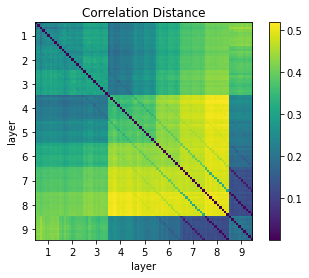

In [139]:
from matplotlib.pyplot import imshow
plt.title('Correlation Distance')
plt.xlabel('layer')
plt.xticks(ticks=[5, 15, 25, 35, 45, 55, 65, 75, 85],
           labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.yticks(ticks=[5, 15, 25, 35, 45, 55, 65, 75, 85],
           labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.ylabel('layer')

plt.imshow(svcca_correlations_distance)
plt.colorbar()

In [110]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2, dissimilarity='precomputed')

X_transformed = embedding.fit_transform(svcca_correlations_distance)
X_transformed.shape

(90, 2)

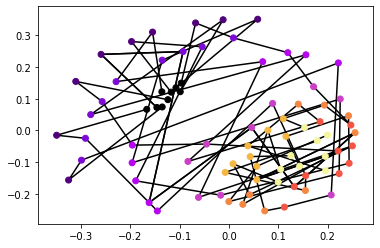

In [111]:
colors = ['#f5f59d', '#f5b642', '#f58742', '#f55442', '#c940c5',
          '#b407ed', '#7d09d6', '#50017a', '#000000']
plt.plot(X_transformed[::10, 0], X_transformed[::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[1::10, 0], X_transformed[1::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[2::10, 0], X_transformed[2::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[3::10, 0], X_transformed[3::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[4::10, 0], X_transformed[4::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[5::10, 0], X_transformed[5::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[6::10, 0], X_transformed[6::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[7::10, 0], X_transformed[7::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[8::10, 0], X_transformed[8::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[::10, 0], X_transformed[::10, 1], linestyle='-', color='black', zorder=1)

plt.scatter(X_transformed[::10, 0], X_transformed[::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[1::10, 0], X_transformed[1::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[2::10, 0], X_transformed[2::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[3::10, 0], X_transformed[3::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[4::10, 0], X_transformed[4::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[5::10, 0], X_transformed[5::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[6::10, 0], X_transformed[6::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[7::10, 0], X_transformed[7::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[8::10, 0], X_transformed[8::10, 1], marker='o', color=colors, zorder=2)


In [2]:
svcca_thresholds = np.load('all_cnn_c_version_1_thresholds.npy')
svcca_thresholds

array([ 64.,  60.,  53.,  60.,  63.,  61.,  63.,  61.,  62.,  60.,  68.,
        68.,  61.,  67.,  71.,  73.,  73.,  70.,  70.,  69.,  76.,  81.,
        75.,  80.,  78.,  81.,  80.,  81.,  78.,  78., 172., 178., 177.,
       176., 171., 178., 176., 176., 176., 178., 178., 180., 182., 181.,
       178., 181., 181., 181., 181., 181., 184., 184., 185., 185., 183.,
       185., 184., 184., 184., 185., 186., 185., 186., 185., 185., 185.,
       185., 185., 185., 185., 185., 183., 184., 183., 185., 183., 184.,
       185., 184., 183.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,
        10.,  10.])

In [18]:
# Calculate consistency of thresholds per layer (standard dev)
# Note: thresholds organized by (Instance1_layer1, Instance1_layer2 ... Instance2_layer1 ... InstanceN_layer_M)
num_layers = 9
num_instances = 10
threshold_consistencies = []
for layer in range(num_layers):
    threshold_consistencies.append(
        np.std(svcca_thresholds[layer*num_instances : (layer+1)*num_instances]))

In [19]:
threshold_consistencies

[2.9,
 3.286335345030997,
 2.0396078054371136,
 2.315167380558045,
 1.2806248474865698,
 0.6403124237432849,
 0.4,
 0.8306623862918076,
 0.0]

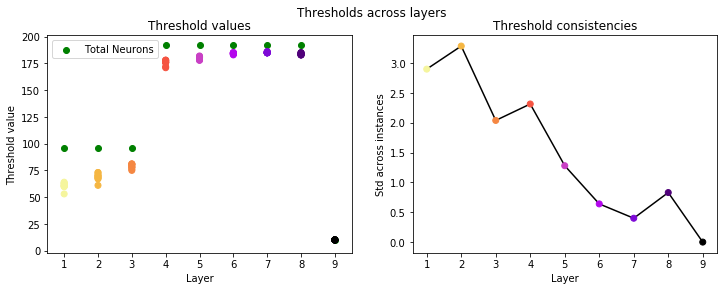

In [39]:
colors = ['#f5f59d', '#f5b642', '#f58742', '#f55442', '#c940c5',
          '#b407ed', '#7d09d6', '#50017a', '#000000']
total_neurons = [96, 96, 96, 192, 192, 192, 192, 192, 10]
layers = [1, 2, 3, 4, 5, 6, 7, 8, 9]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
fig.suptitle('Thresholds across layers')

axes[0].set(title='Threshold values', xlabel='Layer', ylabel='Threshold value')
axes[0].scatter(layers, total_neurons, color='green', label='Total Neurons')
axes[0].legend(loc='upper left')
axes[0].scatter(layers, svcca_thresholds[::10], color=colors)
axes[0].scatter(layers, svcca_thresholds[1::10], color=colors)
axes[0].scatter(layers, svcca_thresholds[2::10], color=colors)
axes[0].scatter(layers, svcca_thresholds[3::10], color=colors)
axes[0].scatter(layers, svcca_thresholds[4::10], color=colors)
axes[0].scatter(layers, svcca_thresholds[5::10], color=colors)
axes[0].scatter(layers, svcca_thresholds[6::10], color=colors)
axes[0].scatter(layers, svcca_thresholds[7::10], color=colors)
axes[0].scatter(layers, svcca_thresholds[8::10], color=colors)
axes[0].scatter(layers, svcca_thresholds[9::10], color=colors)

axes[1].set(title='Threshold consistencies', xlabel='Layer', ylabel='Std across instances')
axes[1].scatter(layers, threshold_consistencies, color=colors, zorder=2)
axes[1].plot(layers, threshold_consistencies, color='black', zorder=1)


## Testing PWCCA instead
It looks like SVCCA cares more about the size of the activations than anything else so seeing if PWCCA works any differently

In [40]:
num_images = len(x_predict) # 1000
num_networks = 10
num_layers = 9
rep_list = [[], [], [], [], [], [], [], [], []]

# Loop through network instances
for i in range(num_networks):
    print('Working on model', str(i))
    K.clear_session()
    full_model = load_model('Models/Primary/Version_1/all_cnn_c_' + str(i) + '.h5')
    inp = full_model.input
    # Loop through layers
    for j in range(num_layers):
        print('Layer', str(j))
        out = full_model.layers[j].output
        temp_model = Model(inputs=inp, outputs=out)
        # Predict on x_predict
        print('Getting representation...')
        representations = temp_model.predict(x_predict)
        print('Old shape:', representations.shape)
        # Average pool along spacial dimensions, transpose to fit shape (imgs, neurons)
        if (len(representations.shape) > 2):
            avg = np.mean(representations, axis=(1,2)).T
            print('Avg shape:', avg.shape)
        else:
            avg = representations.T
            print('No need to flatten')
        rep_list[j].append(avg)

Working on model 0
Layer 0
Getting representation...
Old shape: (1000, 32, 32, 96)
Avg shape: (96, 1000)
Layer 1
Getting representation...
Old shape: (1000, 32, 32, 96)
Avg shape: (96, 1000)
Layer 2
Getting representation...
Old shape: (1000, 16, 16, 96)
Avg shape: (96, 1000)
Layer 3
Getting representation...
Old shape: (1000, 16, 16, 192)
Avg shape: (192, 1000)
Layer 4
Getting representation...
Old shape: (1000, 16, 16, 192)
Avg shape: (192, 1000)
Layer 5
Getting representation...
Old shape: (1000, 8, 8, 192)
Avg shape: (192, 1000)
Layer 6
Getting representation...
Old shape: (1000, 8, 8, 192)
Avg shape: (192, 1000)
Layer 7
Getting representation...
Old shape: (1000, 8, 8, 192)
Avg shape: (192, 1000)
Layer 8
Getting representation...
Old shape: (1000, 8, 8, 10)
Avg shape: (10, 1000)
Working on model 1
Layer 0
Getting representation...
Old shape: (1000, 32, 32, 96)
Avg shape: (96, 1000)
Layer 1
Getting representation...
Old shape: (1000, 32, 32, 96)
Avg shape: (96, 1000)
Layer 2
Gettin

In [134]:
import pwcca

print('Done preprocessing representations and thresholds, now CCA')
pwcca_correlations = np.empty((num_layers * num_networks, num_layers * num_networks))
for i in range(pwcca_correlations.shape[0]):
    for j in range(pwcca_correlations.shape[1]):
        print('Correlation', str(i), ',', str(j))
        
        layer_i = i // num_networks
        network_i = i % num_networks
        layer_j = j // num_networks
        network_j = j % num_networks
        
        # pwcca is order-dependent, so swap around to make symmetric
        if (i >= j):
            acts1 = rep_list[layer_i][network_i]
            acts2 = rep_list[layer_j][network_j]
        else:
            acts1 = rep_list[layer_j][network_j]
            acts2 = rep_list[layer_i][network_i]        
        
        # Do pwcca, acts1 needs to have dim <= acts2
        if (acts1.shape[0] <= acts2.shape[0]):
            pwcca_correlations[i, j] = pwcca.compute_pwcca(acts1, acts2)[0]
        else:
            pwcca_correlations[i, j] = pwcca.compute_pwcca(acts2, acts1)[0]

np.save('pwcca_correlations.npy', pwcca_correlations)
print('Done!')

Done preprocessing representations and thresholds, now CCA
Correlation 0 , 0
Correlation 0 , 1
Correlation 0 , 2
Correlation 0 , 3
Correlation 0 , 4
Correlation 0 , 5
Correlation 0 , 6
Correlation 0 , 7
Correlation 0 , 8
Correlation 0 , 9
Correlation 0 , 10
Correlation 0 , 11
Correlation 0 , 12
Correlation 0 , 13
Correlation 0 , 14
Correlation 0 , 15
Correlation 0 , 16
Correlation 0 , 17
Correlation 0 , 18
Correlation 0 , 19
Correlation 0 , 20
Correlation 0 , 21
Correlation 0 , 22
Correlation 0 , 23
Correlation 0 , 24
Correlation 0 , 25
Correlation 0 , 26
Correlation 0 , 27
Correlation 0 , 28
Correlation 0 , 29
Correlation 0 , 30
Correlation 0 , 31
Correlation 0 , 32
Correlation 0 , 33
Correlation 0 , 34
Correlation 0 , 35
Correlation 0 , 36
Correlation 0 , 37
Correlation 0 , 38
Correlation 0 , 39
Correlation 0 , 40
Correlation 0 , 41
Correlation 0 , 42
Correlation 0 , 43
Correlation 0 , 44
Correlation 0 , 45
Correlation 0 , 46
Correlation 0 , 47
Correlation 0 , 48
Correlation 0 , 49
C

In [135]:
pwcca_correlations = np.load('pwcca_correlations.npy')
pwcca_correlations_distance = 1 - pwcca_correlations

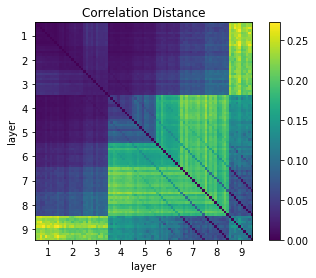

In [138]:
from matplotlib.pyplot import imshow
plt.title('Correlation Distance')
plt.xlabel('layer')
plt.xticks(ticks=[5, 15, 25, 35, 45, 55, 65, 75, 85],
           labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.yticks(ticks=[5, 15, 25, 35, 45, 55, 65, 75, 85],
           labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.ylabel('layer')

plt.imshow(pwcca_correlations_distance)
plt.colorbar()

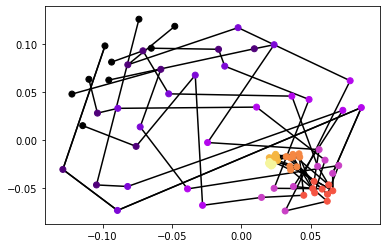

In [137]:
# pwcca_correlations_distance.shape
from sklearn.manifold import MDS
embedding = MDS(n_components=2, dissimilarity='precomputed')

X_transformed = embedding.fit_transform(pwcca_correlations_distance.astype('float64'))
X_transformed.shape

colors = ['#f5f59d', '#f5b642', '#f58742', '#f55442', '#c940c5',
          '#b407ed', '#7d09d6', '#50017a', '#000000']
plt.plot(X_transformed[::10, 0], X_transformed[::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[1::10, 0], X_transformed[1::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[2::10, 0], X_transformed[2::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[3::10, 0], X_transformed[3::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[4::10, 0], X_transformed[4::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[5::10, 0], X_transformed[5::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[6::10, 0], X_transformed[6::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[7::10, 0], X_transformed[7::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[8::10, 0], X_transformed[8::10, 1], linestyle='-', color='black', zorder=1)
plt.plot(X_transformed[::10, 0], X_transformed[::10, 1], linestyle='-', color='black', zorder=1)

plt.scatter(X_transformed[::10, 0], X_transformed[::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[1::10, 0], X_transformed[1::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[2::10, 0], X_transformed[2::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[3::10, 0], X_transformed[3::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[4::10, 0], X_transformed[4::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[5::10, 0], X_transformed[5::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[6::10, 0], X_transformed[6::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[7::10, 0], X_transformed[7::10, 1], marker='o', color=colors, zorder=2)
plt.scatter(X_transformed[8::10, 0], X_transformed[8::10, 1], marker='o', color=colors, zorder=2)


In [133]:
# Familiarizing with PWCCA
acts1_test = rep_list[8][0]
acts2_test = rep_list[8][4]

res = pwcca.compute_pwcca(acts1_test, acts2_test, epsilon=1e-10)
res[0]

0.8751055194031298